In [7]:
import requests
import csv
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
print(tf.__version__)


2.5.0-dev20201206


In [8]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [9]:
# r = requests.get('http://www.chp.gov.hk/files/misc/building_list_eng.csv')
# content = r.json()
# print(r.content)
class covid_dataset():
    headers = 'case_number, report_date, date_of_onset, gender, age, patient_status, residence, confirm_status, date, confirmed_case_per_day, death_cases, discharge_cases, probable_cases, critical_condition_cases'
    case_number = list()
    report_date = list()
    date_of_onset = list()
    gender = list()
    age = list()
    patient_status = list()
    residence = list()
    classification = list()
    confirm_status = list()

    district = list()
    case_number_1 = list()
    building_name = list()

    date = list()
    confirmed_case = list()
    confirmed_case_per_day = list()
    death_cases = list()
    discharge_cases = list()
    probable_cases = list()
    critical_condition_cases = list()

    os.system('wget -O building_list_eng.csv http://www.chp.gov.hk/files/misc/building_list_eng.csv')
    os.system('wget -O enhanced_sur_covid_19_eng.csv http://www.chp.gov.hk/files/misc/enhanced_sur_covid_19_eng.csv')
    os.system('wget -O latest_situation_of_reported_cases_covid_19_eng.csv http://www.chp.gov.hk/files/misc/latest_situation_of_reported_cases_covid_19_eng.csv')

    with open('latest_situation_of_reported_cases_covid_19_eng.csv', newline='') as csvfile:
        rows = csv.reader(csvfile)
        # # 以迴圈輸出每一列
        first_row = True
        first_data = True
        cache_value = 0
        for row in rows:
            if first_row:
                first_row = False
                continue
            if not first_row:
                date.append(row[0])
                confirmed_case.append(row[2])
                if first_data == True:
                    confirmed_case_per_day.append(int(row[2]))
                    first_data = False
                elif first_data == False:
                    confirmed_case_per_day.append(int(row[2])-cache_value)
                    cache_value = int(row[2])
                death_cases.append(row[6])
                discharge_cases.append(row[7])
                probable_cases.append(row[8])
                critical_condition_cases.append(row[9])

    with open('enhanced_sur_covid_19_eng.csv', newline='') as csvfile:
        rows = csv.reader(csvfile)
        # # 以迴圈輸出每一列
        for row in rows:
            if first_row:
                first_row = False
                continue
            if not first_row:
                case_number.append(row[0])
                report_date.append(row[1])
                date_of_onset.append(row[2])
                gender.append(row[3])
                age.append(row[4])
                patient_status.append(row[6])
                residence.append(row[7])
                confirm_status.append(row[8])

    with open('building_list_eng.csv', newline='') as csvfile:
        rows = csv.reader(csvfile)

        # # 以迴圈輸出每一列
        for row in rows:
            if first_row:
                first_row = False
                continue
            if not first_row:
                district.append(row[0])
                building_name.append(row[1])
                case_number_1.append(row[3])




class extract_info:
    def __init__(self, object_name, case_number=None):
        self.headers = 'case_number, report_date, date_of_onset, gender, age, patient_status, residence, confirm_status, date, confirmed_case_per_day, death_cases, discharge_cases, probable_cases, critical_condition_cases'
        self.object = object_name
        self.case = case_number
        self.result = list()

        switcher = {
            'case_number':covid_dataset.case_number,
            'report_date':covid_dataset.report_date,
            'date_of_onset':covid_dataset.date_of_onset,
            'gender':covid_dataset.gender,
            'age':covid_dataset.age,
            'patient_status':covid_dataset.patient_status,
            'residence':covid_dataset.residence,
            'confirm_status':covid_dataset.confirm_status,
            'date':covid_dataset.date,
            'confirmed_case_per_day':covid_dataset.confirmed_case_per_day,
            'death_cases':covid_dataset.death_cases,
            'discharge_cases':covid_dataset.discharge_cases,
            'probable_cases':covid_dataset.probable_cases,
            'critical_condition_cases':covid_dataset.critical_condition_cases,
        }

        if self.case == None:
            # return switcher.get(self.object)
            self.result=switcher.get(self.object)

        elif self.case >= 0 and isinstance(self.case, int):
            # return switcher.get(self.object)[self.case+1]
            self.result = switcher.get(self.object)[self.case+1]


In [14]:
print(covid_dataset.confirmed_case_per_day)
time = range(0, len(covid_dataset.confirmed_case_per_day))
cases_perday=covid_dataset.confirmed_case_per_day
series = np.array(covid_dataset.confirmed_case_per_day)
# plt.plot(x, y)
# plt.show()


split_time = 320
time_train = time[:split_time]
x_train = series[:split_time]
print(x_train.shape)
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 5
batch_size = 20
shuffle_buffer_size = 1000

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Number of cases")
    plt.grid(True)

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 5
batch_size = 20
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
# print(x_train.shape)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

# lr_schedule = tf.keras.callbacks.LearningRateScheduler(
#     lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 3, 0, 0, 2, 2, 1, 1, 1, 0, 3, 3, 3, 2, 0, 10, 6, 7, 1, 3, 3, 0, 1, 3, 1, 2, 4, 1, 0, 6, 3, 8, 6, 1, 2, 0, 3, 2, 1, 3, 1, 2, 2, 5, 2, 2, 12, 1, 2, 7, 8, 9, 8, 20, 22, 44, 23, 44, 34, 31, 25, 45, 42, 32, 51, 46, 57, 57, 47, 47, 22, 29, 32, 21, 25, 13, 16, 11, 4, 5, 3, 4, 1, 4, 2, 2, 0, 4, 4, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 4, 0, 0, 3, 0, 0, 3, 1, 1, 0, 3, 0, 0, 0, 8, 2, 0, 0, 0, 0, 1, 0, 13, 3, 2, 3, 6, 0, 6, 3, 3, 1, 1, 0, 0, 0, 1, 1, 0, 3, 0, 8, 4, 3, 1, 3, 30, 16, 2, 14, 3, 1, 2, 4, 2, 28, 9, 5, 11, 10, 17, 14, 24, 42, 38, 28, 38, 52, 48, 19, 67, 58, 64, 108, 73, 60, 113, 118, 123, 133, 128, 145, 106, 118, 149, 121, 124, 115, 78, 80, 85, 95, 89, 69, 72, 69, 33, 62, 69, 48, 46, 74, 44, 36, 26, 18, 27, 26, 25, 9, 19, 24, 21, 13, 18, 15, 9, 12, 8, 8, 12, 7, 21, 11, 6, 6, 12, 12, 13, 19, 14, 4, 9, 9, 3, 13, 23, 6, 8, 3, 7, 2, 1, 6, 10, 4, 8, 10, 7, 4, 5, 11, 8, 11, 18, 8, 6, 7, 11, 8, 0, 12, 7, 17, 4, 15, 5, 8, 11, 4, 5, 6, 

In [15]:
history = model.fit(train_set, epochs=200) #, callbacks=[lr_schedule]
model.save('test_model.h5')

# plt.semilogx(history.history["lr"], history.history["loss"])
# plt.axis([1e-8, 1e-4, 0, 60])
# plt.show()


Epoch 1/200
16/16 [==============================] - 4s 115ms/step - loss: 14.4860 - mae: 14.9506
Epoch 2/200
16/16 [==============================] - 0s 6ms/step - loss: 11.7904 - mae: 12.2740
Epoch 3/200
16/16 [==============================] - 0s 6ms/step - loss: 11.4188 - mae: 11.8953
Epoch 4/200
16/16 [==============================] - 0s 6ms/step - loss: 11.0603 - mae: 11.5393
Epoch 5/200
16/16 [==============================] - 0s 6ms/step - loss: 11.0183 - mae: 11.4969
Epoch 6/200
16/16 [==============================] - 0s 6ms/step - loss: 11.3417 - mae: 11.8249
Epoch 7/200
16/16 [==============================] - 0s 6ms/step - loss: 10.4003 - mae: 10.8802
Epoch 8/200
16/16 [==============================] - 0s 6ms/step - loss: 9.9326 - mae: 10.4115
Epoch 9/200
16/16 [==============================] - 0s 6ms/step - loss: 9.5444 - mae: 10.0231
Epoch 10/200
16/16 [==============================] - 0s 6ms/step - loss: 9.0313 - mae: 9.5029
Epoch 11/200
16/16 [=====================

16/16 [==============================] - 0s 6ms/step - loss: 5.9834 - mae: 6.4461
Epoch 88/200
16/16 [==============================] - 0s 6ms/step - loss: 5.5112 - mae: 5.9783
Epoch 89/200
16/16 [==============================] - 0s 6ms/step - loss: 6.5302 - mae: 7.0085
Epoch 90/200
16/16 [==============================] - 0s 6ms/step - loss: 6.0895 - mae: 6.5633
Epoch 91/200
16/16 [==============================] - 0s 6ms/step - loss: 5.7631 - mae: 6.2252
Epoch 92/200
16/16 [==============================] - 0s 6ms/step - loss: 5.5246 - mae: 5.9954
Epoch 93/200
16/16 [==============================] - 0s 6ms/step - loss: 5.5772 - mae: 6.0441
Epoch 94/200
16/16 [==============================] - 0s 6ms/step - loss: 5.8796 - mae: 6.3434
Epoch 95/200
16/16 [==============================] - 0s 6ms/step - loss: 5.6493 - mae: 6.1100
Epoch 96/200
16/16 [==============================] - 0s 6ms/step - loss: 5.7272 - mae: 6.1940
Epoch 97/200
16/16 [==============================] - 0s 6ms/st

16/16 [==============================] - 0s 6ms/step - loss: 5.5801 - mae: 6.0483
Epoch 173/200
16/16 [==============================] - 0s 6ms/step - loss: 5.4627 - mae: 5.9313
Epoch 174/200
16/16 [==============================] - 0s 6ms/step - loss: 5.0482 - mae: 5.5156
Epoch 175/200
16/16 [==============================] - 0s 6ms/step - loss: 5.2726 - mae: 5.7331
Epoch 176/200
16/16 [==============================] - 0s 6ms/step - loss: 5.0299 - mae: 5.4917
Epoch 177/200
16/16 [==============================] - 0s 6ms/step - loss: 5.8540 - mae: 6.3261
Epoch 178/200
16/16 [==============================] - 0s 6ms/step - loss: 5.6600 - mae: 6.1397
Epoch 179/200
16/16 [==============================] - 0s 6ms/step - loss: 5.3427 - mae: 5.8146
Epoch 180/200
16/16 [==============================] - 0s 6ms/step - loss: 4.8217 - mae: 5.2863
Epoch 181/200
16/16 [==============================] - 0s 6ms/step - loss: 5.5368 - mae: 6.0032
Epoch 182/200
16/16 [==============================] -

2.5.0-dev20201206
344


<Figure size 720x432 with 0 Axes>

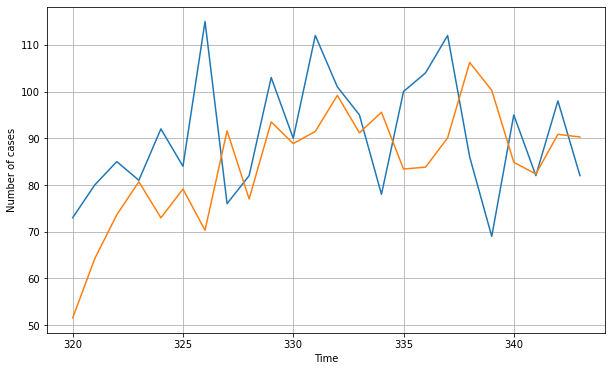

89.63067
86.40387
84.68638
84.6778
78.763535
74.49599
65.37433
65.682785
62.7681
57.680767
55.24173
52.82833
51.71388
50.28574
46.636944
45.280163
43.79831
41.774208
40.348732
37.941563
36.564114
35.360474
32.79864
31.511665
29.938566
28.28621
27.455574
25.499788
24.33123
23.714275
22.126425
21.537298
20.680052
19.630707
19.60127
18.463295
17.828289
17.717453
16.6647
16.602379
16.029251
15.361086
15.526658
14.748994
14.61533
14.507282
13.947746
14.115077
13.727888
13.576797
13.640719
13.2848
13.391286
13.229561
13.13301
13.222679
13.019583
13.087577
13.052305
12.974554


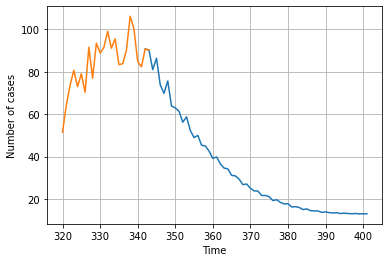

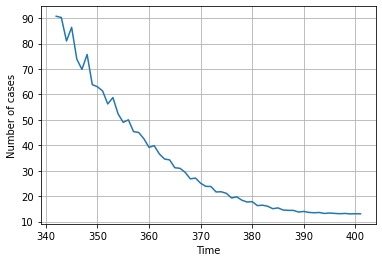

In [16]:
plt.figure(figsize=(10, 6))
raw_data = np.array(cases_perday[0:])
raw_days = range(0,len(raw_data))

# plot_series(raw_days, raw_data)

# plt.show()

print(tf.__version__)
datas_prediction = []
print(len(covid_dataset.confirmed_case_per_day))
series_prediction = np.array([])
model = tf.keras.models.load_model('test_model.h5')
datas_prediction = np.array(cases_perday)

prediction_days = 60
forward_day = 2


rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

# print(tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy())

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)
plt.show()


for i in range(prediction_days):
#     print(len(datas_prediction))
    # print(type(datas[333]))
    # print(type(model.predict(series[len(datas)-5:len(datas),np.newaxis][np.newaxis])[0,-1,0]))
    series_prediction = np.array(datas_prediction)
    datas_prediction = np.append(datas_prediction, float(model.predict(series_prediction[len(datas_prediction)-window_size-forward_day:len(datas_prediction)-forward_day,np.newaxis][np.newaxis])[0,-1,0]))
    print(model.predict(series_prediction[len(datas_prediction)-window_size:len(datas_prediction),np.newaxis][np.newaxis])[0,-1,0])

time_valid_prediction = range(len(cases_perday)-forward_day,len(cases_perday)+prediction_days-forward_day)
x_valid_prediction = datas_prediction[len(datas_prediction)-prediction_days:len(datas_prediction)]


plot_series(time_valid_prediction, x_valid_prediction)
plot_series(time_valid, rnn_forecast)
plt.show()

plot_series(time_valid_prediction, x_valid_prediction)
plt.show()

In [ ]:
# print(tf.__version__)
# model = tf.keras.models.load_model('test_model.h5')
# datas = covid_dataset.confirmed_case_per_day
# # for i in range(10):
# #     datas.append(0)
# # print(datas)
# series = np.array(datas)
# current_time = 333
# time_valid = range(current_time, len(datas))
# x_valid = series[current_time:]


# def plot_series(time, series, format="-", start=0, end=None):
#     plt.plot(time[start:end], series[start:end], format)
#     plt.xlabel("Time")
#     plt.ylabel("Value")
#     plt.grid(True)

# def model_forecast(model, series, window_size):
#     ds = tf.data.Dataset.from_tensor_slices(series)
#     ds = ds.window(window_size, shift=1, drop_remainder=True)
#     ds = ds.flat_map(lambda w: w.batch(window_size))
#     ds = ds.batch(32).prefetch(1)
#     print(type(ds))
#     forecast = model.predict(ds)
#     return forecast

# window_size = 5
# print(series[329:370, np.newaxis])
# rnn_forecast = model_forecast(model, series[330:350, np.newaxis], window_size)
# # rnn_forecast = rnn_forecast[current_time - window_size:-1, -1, 0]
# #series[..., np.newaxis]

# # print(series[34:50, np.newaxis])
# prediction = model.predict(series[330:335, np.newaxis])
# print(prediction)
# print(rnn_forecast)
# print(rnn_forecast.shape)

# # print(tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy())
# # time_valid = range(34, 300)
# # print(time_valid)
# # plt.figure(figsize=(10, 6))
# # plot_series(time_valid, x_valid)
# # plot_series(time_valid, rnn_forecast)
# # plt.show(